In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the location dataset

data_path = "../data/interim/location_data.csv"

df_reader = pd.read_csv(data_path, chunksize=100000)

df_reader

In [3]:
# do sampling

all_samples = []

df_reader = pd.read_csv(data_path, chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500))


sample_df = pd.concat(all_samples, axis=0)

In [4]:
# size of sample df

sample_df.shape

(166500, 2)

In [5]:
sample_df

,pickup_latitude,pickup_longitude
97471,40.750620,-73.994670
47138,40.729725,-73.980890
30090,40.748627,-73.984344
47489,40.723312,-73.982450
20580,40.718857,-73.988770
...,...,...
33204090,40.755867,-73.976150
33203132,40.782580,-73.959720
33216486,40.758804,-73.964070
33208507,40.752560,-73.970410


Text(0, 0.5, 'Longitude')

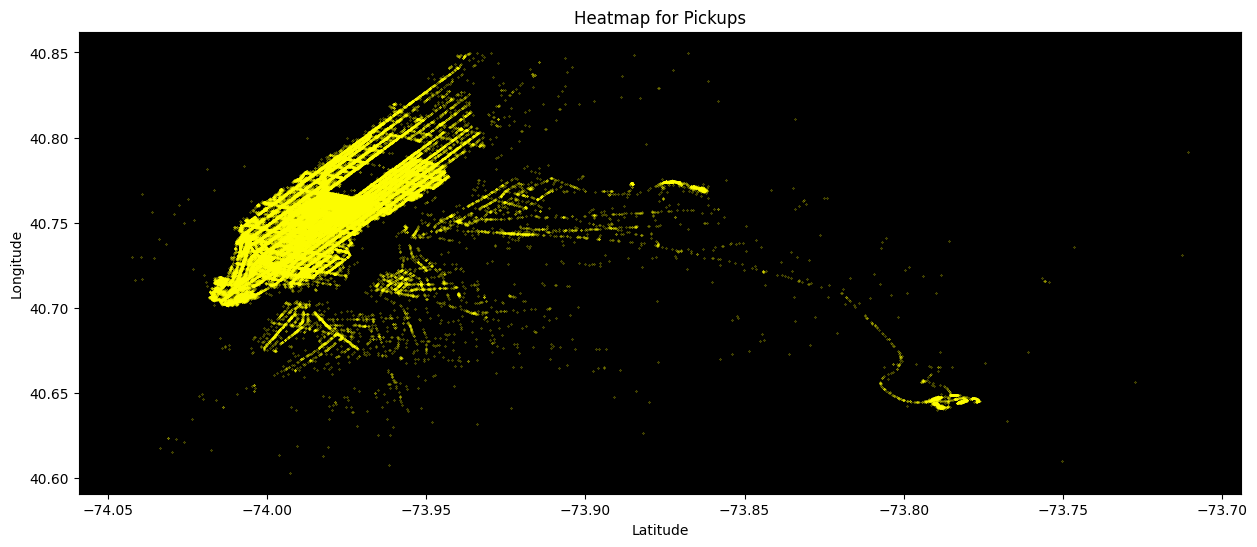

In [6]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [8]:
from sklearn import set_config

set_config(transform_output='pandas')

In [9]:
# scale the input columns

from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_sample_df = scale_samples.fit_transform(sample_df)

In [10]:
scaled_sample_df

,pickup_latitude,pickup_longitude
97471,-0.016004,-0.559776
47138,-0.783798,-0.184660
30090,-0.089237,-0.278684
47489,-1.019446,-0.227126
20580,-1.183147,-0.399167
...,...,...
33204090,0.176799,-0.055629
33203132,1.158379,0.391624
33216486,0.284721,0.273209
33208507,0.055283,0.100624


Text(0, 0.5, 'Longitude')

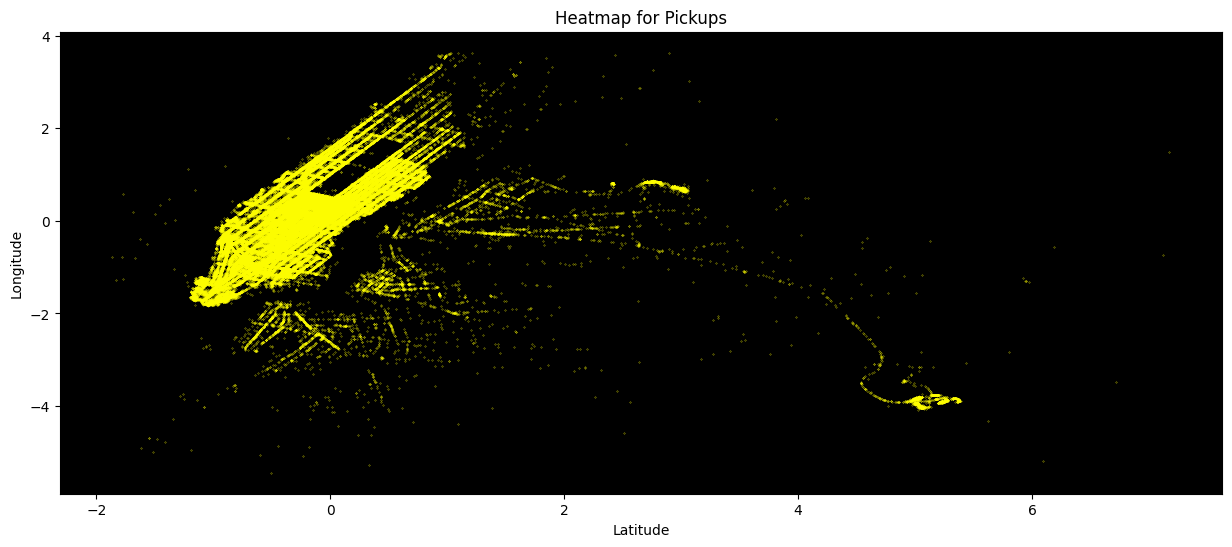

In [11]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [12]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [13]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [14]:
# train the standard scaler

scaler = StandardScaler()

for chunk in df_reader:
    # fit the scaler
    scaler.partial_fit(chunk)

In [15]:
scaler

,copy,True
,with_mean,True
,with_std,True


In [16]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.75109344 -73.97410182]
The sigma values are  [0.02718247 0.03665206]


In [17]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [18]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
        
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [19]:
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [20]:
# select the optimum value of K

select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 7 and is 35.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 11 and is 36.7% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 11 and is 27.5% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 10 and is 20.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 10 and is 14.3% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 15 and is 16.7% regions of total


In [21]:
df_reader = pd.read_csv(data_path, chunksize=100000)
mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)
    
# centroid values
centroids = mini_batch.cluster_centers_

centroids

array([[ 1.45162474,  0.05484529],
       [-0.66229522, -0.74738941],
       [-3.85562685,  5.17052428],
       [ 0.4457997 ,  0.19350057],
       [-2.27003435, -0.34512659],
       [ 0.27475023, -0.44825685],
       [-0.62114294,  2.91901232],
       [-0.40489983, -0.35380749],
       [-0.06028848, -0.45898315],
       [ 2.70745298,  0.85181012],
       [ 1.29850109,  0.62806028],
       [-2.14411353,  1.1057445 ],
       [ 0.63846686,  0.50681994],
       [ 0.52265625,  1.47725324],
       [-3.10900783,  0.02071979],
       [-0.07806558, -0.10017757],
       [-1.05928164, -0.76037833],
       [-0.27631061, -0.78643964],
       [ 0.98260739, -0.19016816],
       [-0.76048908, -0.34099819],
       [-0.13383833,  1.17418056],
       [ 0.20431178,  0.04455186],
       [ 0.50404648, -0.21692972],
       [-1.50538321, -1.00124992],
       [-1.30725161,  0.51826188],
       [ 0.99456546,  0.58760698],
       [ 0.7656563 ,  2.86070223],
       [ 0.84283483,  0.33451723],
       [-1.09596766,

In [22]:
centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

centroids.shape

centroids

array([[ 40.79055219, -73.97209163],
       [ 40.73309063, -74.00149519],
       [ 40.64628799, -73.78459145],
       [ 40.76321138, -73.96700963],
       [ 40.68938831, -73.98675143],
       [ 40.75856183, -73.99053136],
       [ 40.73420925, -73.86711401],
       [ 40.74008727, -73.9870696 ],
       [ 40.74945465, -73.9909245 ],
       [ 40.8246887 , -73.94288123],
       [ 40.78638991, -73.95108212],
       [ 40.69281115, -73.93357401],
       [ 40.76844855, -73.95552583],
       [ 40.76530053, -73.91995745],
       [ 40.66658294, -73.9733424 ],
       [ 40.74897143, -73.97777354],
       [ 40.72229956, -74.00197126],
       [ 40.74358264, -74.00292646],
       [ 40.77780314, -73.98107188],
       [ 40.73042147, -73.98660011],
       [ 40.74745539, -73.93106569],
       [ 40.75664714, -73.97246891],
       [ 40.76479467, -73.98205275],
       [ 40.71017341, -74.0107997 ],
       [ 40.71555912, -73.95510646],
       [ 40.77812819, -73.95256482],
       [ 40.77190587, -73.86925119],
 

In [23]:
# calculate distances
all_distances = []
for i in centroids:
    distances = []
    for j in centroids:
        distance = haversine_distance(i[0], i[1], j[0], j[1])
        distances.append(distance)
    all_distances.append(distances)
all_distances = np.array(all_distances)

In [24]:
all_distances.shape

(30, 30)

In [25]:
# sort array
sorted_distances = np.sort(all_distances, axis=-1)

sorted_distances

array([[ 0.        ,  0.99833944,  1.13607307,  1.19498952,  1.26291786,
         1.33435265,  1.7560306 ,  1.85443606,  1.9077101 ,  2.34272149,
         2.41174985,  2.81013026,  2.88832849,  3.00574041,  3.23799519,
         3.57384032,  3.6243254 ,  3.6709302 ,  4.22349149,  4.25803234,
         4.86676159,  4.96838911,  5.25729064,  5.53257264,  5.91173648,
         6.73331512,  7.03183225,  7.04792692,  8.56579322, 13.99179366],
       [ 0.        ,  0.72879841,  0.74601583,  0.80138014,  0.89670549,
         1.04180156,  1.25881401,  1.65671181,  1.6571534 ,  1.8511255 ,
         2.22662415,  2.41542345,  2.71435244,  2.75495405,  3.11674296,
         3.26907206,  3.42898855,  3.50697611,  3.81830168,  4.03013576,
         4.25803234,  4.51654128,  4.53025034,  4.813394  ,  4.826124  ,
         5.40817905,  7.03274592,  7.03610296,  7.42322188, 12.84932161],
       [ 0.        ,  7.45622343,  8.44348229,  9.74648964,  9.9926065 ,
        10.13580678, 10.37963849, 10.85770405, 11

In [26]:
# nearby regions
region_count = 8
# selected distances
selected_distances = sorted_distances[:, 1:region_count+1]
# average distances
avg_distances = selected_distances.mean(axis=1)

In [27]:
selected_distances

array([[ 0.99833944,  1.13607307,  1.19498952,  1.26291786,  1.33435265,
         1.7560306 ,  1.85443606,  1.9077101 ],
       [ 0.72879841,  0.74601583,  0.80138014,  0.89670549,  1.04180156,
         1.25881401,  1.65671181,  1.6571534 ],
       [ 7.45622343,  8.44348229,  9.74648964,  9.9926065 , 10.13580678,
        10.37963849, 10.85770405, 11.00534358],
       [ 0.53604103,  0.70149092,  0.79322441,  0.79480456,  1.13376992,
         1.24817146,  1.27223157,  1.27811637],
       [ 1.72527484,  1.91032621,  2.20846956,  2.40965872,  2.45302829,
         2.79596378,  2.83516048,  3.11674296],
       [ 0.61834399,  0.62958864,  0.94073372,  0.95455168,  1.2215148 ,
         1.27223157,  1.28928041,  1.41862432],
       [ 2.60701519,  3.47074758,  3.50223777,  4.50516913,  4.78435512,
         5.19730999,  5.404667  ,  5.59978444],
       [ 0.66830139,  0.67795944,  0.78333156,  0.86452056,  0.89670549,
         1.28928041,  1.30223   ,  1.37596266],
       [ 0.62958864,  0.67795944

In [28]:
avg_distances

array([1.43060616, 1.09842258, 9.75216185, 0.96973128, 2.4318281 ,
       1.04310864, 4.38391078, 0.98228644, 0.94766374, 3.25457832,
       1.36632867, 3.36567551, 1.12651189, 2.1986449 , 3.61130907,
       0.99904757, 1.31113023, 1.16897146, 1.26390835, 1.11585024,
       2.19441137, 0.97900353, 0.99821999, 1.93093668, 2.27090497,
       1.19175329, 4.0281918 , 0.96823881, 1.31379214, 1.93484264])

In [29]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

np.float64(0.36666666666666664)

In [31]:
# Clustering
df_reader = pd.read_csv(data_path, chunksize=100000)

In [32]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [33]:
mini_batch

,n_clusters,30
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,10


In [ ]:
# centroids of the model

mini_batch.cluster_centers_

In [34]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.79055219, -73.97209163],
       [ 40.73309063, -74.00149519],
       [ 40.64628799, -73.78459145],
       [ 40.76321138, -73.96700963],
       [ 40.68938831, -73.98675143],
       [ 40.75856183, -73.99053136],
       [ 40.73420925, -73.86711401],
       [ 40.74008727, -73.9870696 ],
       [ 40.74945465, -73.9909245 ],
       [ 40.8246887 , -73.94288123],
       [ 40.78638991, -73.95108212],
       [ 40.69281115, -73.93357401],
       [ 40.76844855, -73.95552583],
       [ 40.76530053, -73.91995745],
       [ 40.66658294, -73.9733424 ],
       [ 40.74897143, -73.97777354],
       [ 40.72229956, -74.00197126],
       [ 40.74358264, -74.00292646],
       [ 40.77780314, -73.98107188],
       [ 40.73042147, -73.98660011],
       [ 40.74745539, -73.93106569],
       [ 40.75664714, -73.97246891],
       [ 40.76479467, -73.98205275],
       [ 40.71017341, -74.0107997 ],
       [ 40.71555912, -73.95510646],
       [ 40.77812819, -73.95256482],
       [ 40.77190587, -73.86925119],
 

In [35]:
# perform predictions and assign clusters

sample_predictions = mini_batch.predict(scaled_sample_df)

sample_predictions.shape

(166500,)

In [36]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

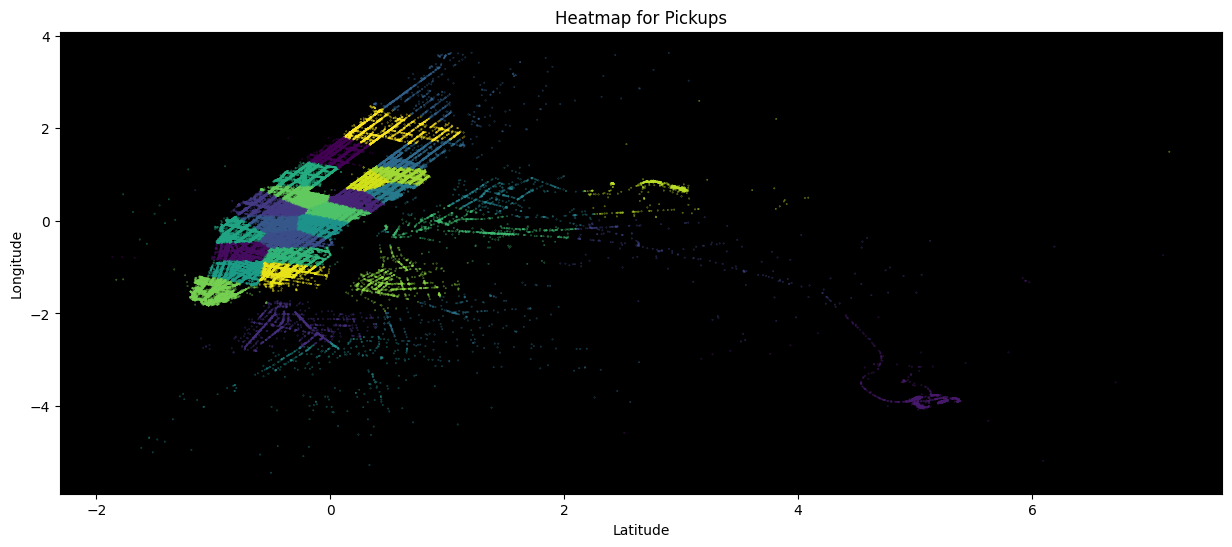

In [37]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()